# Grid algorithm for a beta-binomial hierarchical model

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz
    !pip install empiricaldist

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [4]:
def decorate(**options):
    plt.gca().set(**options)
    legend()
    plt.tight_layout()

In [5]:
from empiricaldist import Cdf

def compare_cdf(pmf, sample):
    pmf.make_cdf().plot(label='grid')
    Cdf.from_seq(sample).plot(label='mcmc')
    print(pmf.mean(), sample.mean())
    decorate()

In [6]:
from empiricaldist import Pmf

def make_pmf(ps, qs, name):
    pmf = Pmf(ps, qs)
    pmf.normalize()
    pmf.index.name = name
    return pmf

## Heart Attack Data

This example is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [7]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [8]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [9]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

## Hospital Data with PyMC

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

In [39]:
import pymc3 as pm

def make_model():
    with pm.Model() as model:
        alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
        beta = pm.Gamma('beta', alpha=4, beta=0.5)
        xs = pm.Beta('xs', alpha, beta, shape=len(data_ns))
        ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    return model

In [46]:
%time model = make_model()

CPU times: user 954 ms, sys: 11 ms, total: 965 ms
Wall time: 997 ms


In [47]:
with model:
    %time trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


CPU times: user 5.39 s, sys: 143 ms, total: 5.54 s
Wall time: 6.41 s


Here's the graph representation of the model, showing that the observable is an array of 13 values.

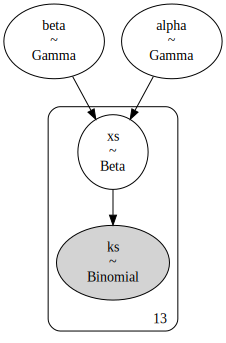

In [48]:
pm.model_to_graphviz(model)

Here are the posterior distributions of alpha and beta.

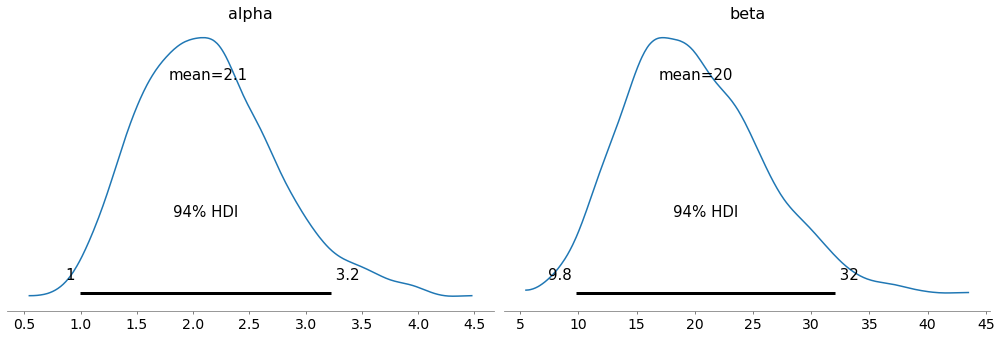

In [49]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta'])

And we can extract the posterior distributions of the xs.

In [50]:
trace_xs = trace['xs'].transpose()
trace_xs.shape

(13, 2000)

As an example, here's the posterior distribution of x for the first hospital.

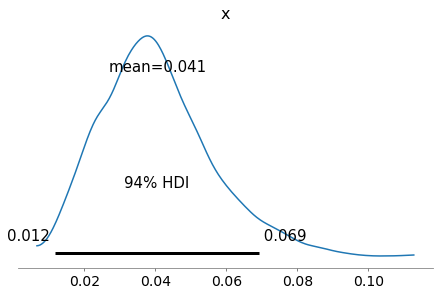

In [51]:
with model:
    az.plot_posterior(trace_xs[0])

## Just one update

In [52]:
i = 3
data_n = data_ns[i]
data_k = data_ks[i]

In [56]:
def make_model1():
    with pm.Model() as model1:
        alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
        beta = pm.Gamma('beta', alpha=4, beta=0.5)
        x = pm.Beta('x', alpha, beta)
        k = pm.Binomial('k', n=data_n, p=x, observed=data_k)
    return model1

In [57]:
model = make_model1()
with model:
    pred1 = pm.sample_prior_predictive(1000)
    trace1 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Here's the graphical representation of the model.

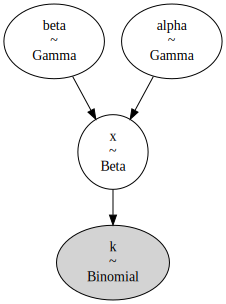

In [54]:
pm.model_to_graphviz(model1)

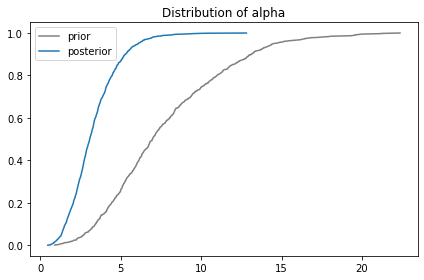

In [18]:
Cdf.from_seq(pred1['alpha']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['alpha']).plot(label='posterior')
decorate(title='Distribution of alpha')

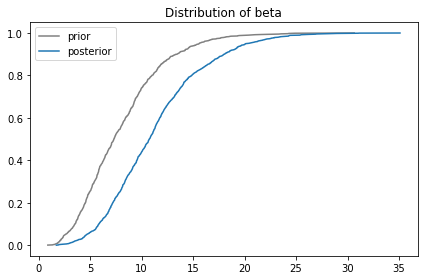

In [19]:
Cdf.from_seq(pred1['beta']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['beta']).plot(label='posterior')
decorate(title='Distribution of beta')

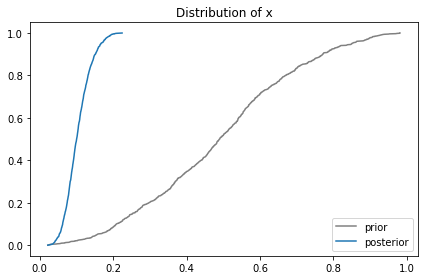

In [20]:
Cdf.from_seq(pred1['x']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['x']).plot(label='posterior')
decorate(title='Distribution of x')

## The grid priors

In [118]:
import numpy as np
from scipy.stats import gamma

alpha = 4
beta = 0.5

alphas = np.linspace(0.1, 80, 100)
ps = gamma(alpha, scale=1/beta).pdf(alphas)
prior_alpha = make_pmf(ps, alphas, 'alpha')

7.999944043634252 7.745861038205821


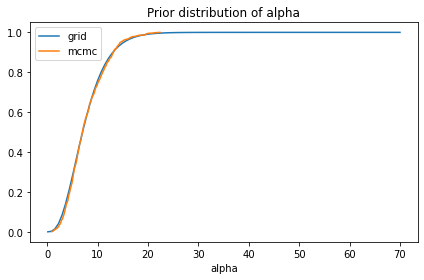

In [22]:
compare_cdf(prior_alpha, pred1['alpha'])
decorate(title='Prior distribution of alpha')

In [23]:
betas = np.linspace(0.1, 80, 90)
ps = gamma(alpha, scale=1/beta).pdf(betas)
prior_beta = make_pmf(ps, betas, 'beta')

7.999899195539326 7.990000166247865


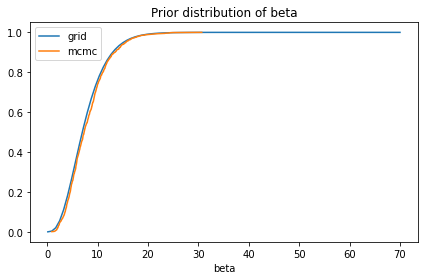

In [24]:
compare_cdf(prior_beta, pred1['beta'])
decorate(title='Prior distribution of beta')

## The joint distribution of hyperparameters

In [25]:
def make_hyper(prior_alpha, prior_beta):
    PA, PB = np.meshgrid(prior_alpha.ps, prior_beta.ps, indexing='ij')
    hyper = PA * PB
    return hyper

In [26]:
prior_hyper = make_hyper(prior_alpha, prior_beta)
prior_hyper.shape

(100, 90)

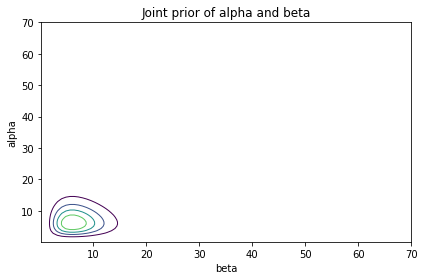

In [27]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(prior_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Joint prior of alpha and beta")

In [28]:
(prior_hyper == 0).sum()

0

## Joint prior of alpha, beta, and x

In [63]:
xs = np.linspace(0.01, 0.99, 99)

TODO: We can speed this up by computing just $x^{\alpha-1} (1-x)^{\beta-1}$ and skipping the terms that don't depend on x

In [64]:
from scipy.stats import beta as betadist

A, B, X = np.meshgrid(alphas, betas, xs, indexing='ij')
betapdf = betadist.pdf(X, A, B)

In [66]:
totals = betapdf.sum(axis=2)

In [67]:
shape = totals.shape + (1,)
betapdf /= totals.reshape(shape)

In [68]:
def make_prior(hyper):

    # reshape hyper so we can multiply along axis 0
    shape = hyper.shape + (1,)
    prior = betapdf * hyper.reshape(shape)

    return prior

In [69]:
%time prior = make_prior(prior_hyper)
prior.sum()

CPU times: user 3 ms, sys: 338 µs, total: 3.34 ms
Wall time: 1.64 ms


0.9999999999999996

The following function computes the marginal distributions.

In [70]:
def marginal(joint, axis):
    axes = [i for i in range(3) if i != axis]
    return joint.sum(axis=tuple(axes))

And let's confirm that the marginal distributions are what they are supposed to be.

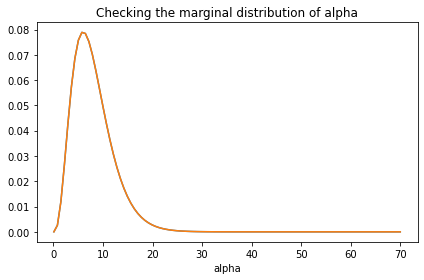

In [71]:
prior_alpha.plot()
marginal_alpha = Pmf(marginal(prior, 0), prior_alpha.qs)
marginal_alpha.plot()
decorate(title='Checking the marginal distribution of alpha')

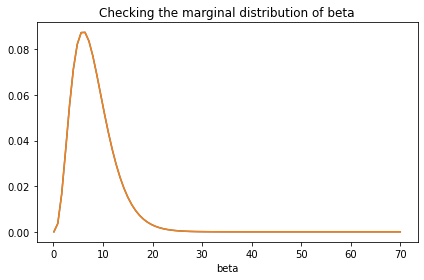

In [72]:
prior_beta.plot()
marginal_beta = Pmf(marginal(prior, 1), prior_beta.qs)
marginal_beta.plot()
decorate(title='Checking the marginal distribution of beta')

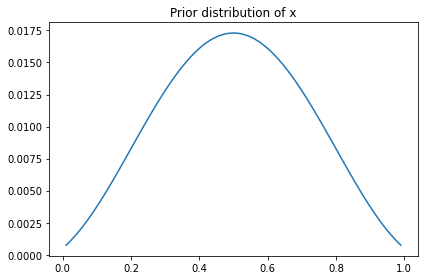

In [73]:
prior_x = Pmf(marginal(prior, 2), xs)
prior_x.plot()
decorate(title='Prior distribution of x')

0.5000025350573485 0.49779400202984764


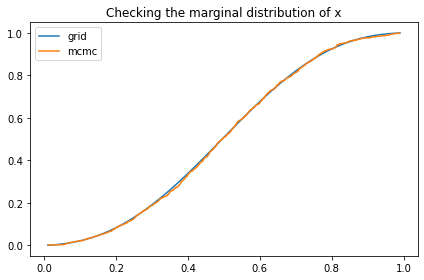

In [74]:
marginal_x = Pmf(marginal(prior, 2), xs)
compare_cdf(marginal_x, pred1['x'])
decorate(title='Checking the marginal distribution of x')

In [75]:
def get_hyper(joint):
    return joint.sum(axis=2)

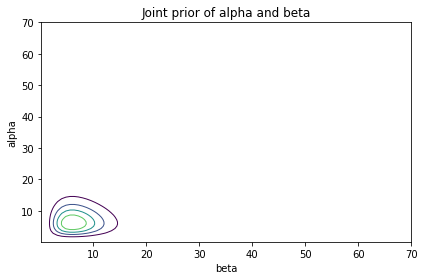

In [77]:
plot_contour(pd.DataFrame(hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Joint prior of alpha and beta")

## The Update

In [78]:
from scipy.stats import binom

like_x = binom.pmf(data_k, data_n, xs)
like_x.shape

(99,)

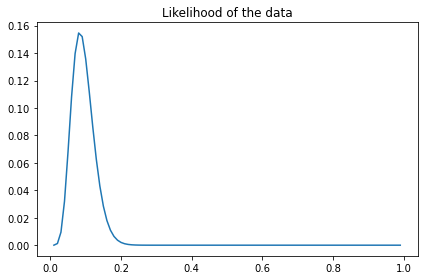

In [79]:
plt.plot(xs, like_x)
decorate(title='Likelihood of the data')

In [80]:
def update(prior, data):
    n, k = data
    like_x = binom.pmf(k, n, xs)

    posterior = prior * like_x
    posterior /= posterior.sum()
    return posterior

In [81]:
data = data_n, data_k
%time posterior = update(prior, data)

CPU times: user 5.26 ms, sys: 172 µs, total: 5.44 ms
Wall time: 3.8 ms


3.285255668788834 3.3067773505681783


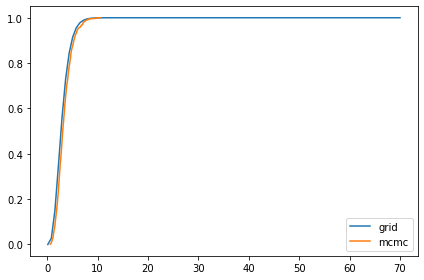

In [82]:
marginal_alpha = Pmf(marginal(posterior, 0), prior_alpha.qs)
compare_cdf(marginal_alpha, trace1['alpha'])

11.371334741114685 11.602546700271098


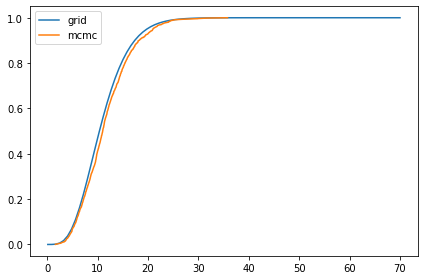

In [83]:
marginal_beta = Pmf(marginal(posterior, 1), prior_beta.qs)
compare_cdf(marginal_beta, trace1['beta'])

0.10410548015625584 0.10483710135384801


(0.10410548015625584, 0.10483710135384801)

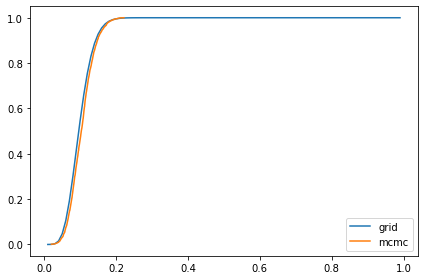

In [84]:
marginal_x = Pmf(marginal(posterior, 2), xs)
compare_cdf(marginal_x, trace1['x'])
marginal_x.mean(), trace1['x'].mean()

In [85]:
posterior_hyper = get_hyper(posterior)

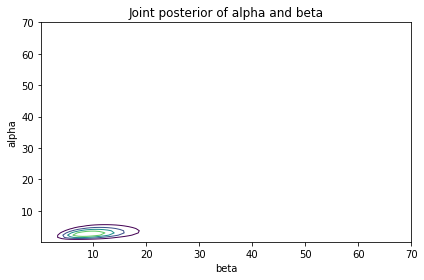

In [86]:
plot_contour(pd.DataFrame(posterior_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Joint posterior of alpha and beta")

In [87]:
like_hyper = posterior_hyper / prior_hyper

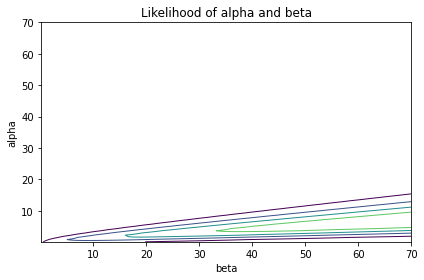

In [88]:
plot_contour(pd.DataFrame(like_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Likelihood of alpha and beta")

## Multiple updates

In [89]:
prior = make_prior(prior_hyper)
prior.shape

(100, 90, 99)

In [90]:
def multiple_updates(prior, ns, ks, xs):
    for data in zip(ns, ks):
        print(data)
        posterior = update(prior, data)
        hyper = get_hyper(posterior)
        prior = make_prior(hyper)
    return posterior

In [91]:
%time posterior = multiple_updates(prior, data_ns, data_ks, xs)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 90.1 ms, sys: 231 µs, total: 90.3 ms
Wall time: 86.4 ms


2.07491852559611 2.1311780237162568


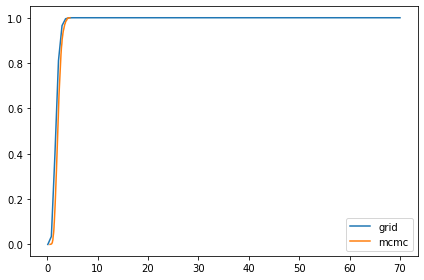

In [92]:
marginal_alpha = Pmf(marginal(posterior, 0), prior_alpha.qs)
compare_cdf(marginal_alpha, trace['alpha'])

19.738988449239404 20.086811012780068


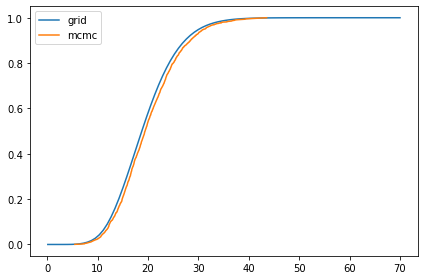

In [93]:
marginal_beta = Pmf(marginal(posterior, 1), prior_beta.qs)
compare_cdf(marginal_beta, trace['beta'])

0.096916352804375 0.09662876760178346


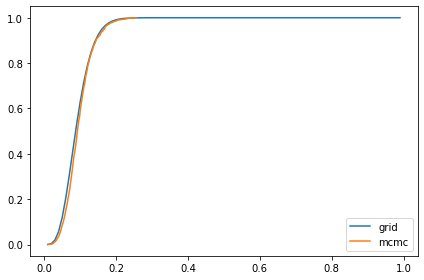

In [94]:
marginal_x = Pmf(marginal(posterior, 2), prior_x.qs)
compare_cdf(marginal_x, trace_xs[-1])

In [95]:
posterior_hyper = get_hyper(posterior)

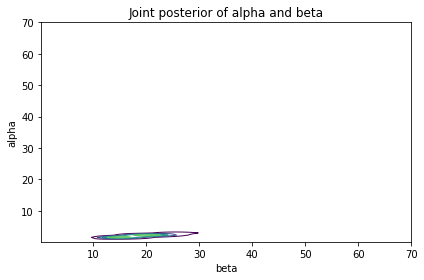

In [96]:
plot_contour(pd.DataFrame(posterior_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Joint posterior of alpha and beta")

In [97]:
like_hyper = posterior_hyper / prior_hyper

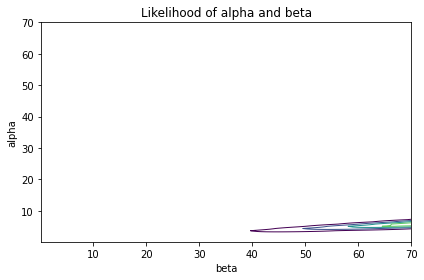

In [98]:
plot_contour(pd.DataFrame(like_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Likelihood of alpha and beta")

## One at a time

In [99]:
def compute_likes_hyper(ns, ks, xs):
    shape = alphas.shape + betas.shape
    uniform_hyper_prior = np.ones(shape)
    prior = make_prior(uniform_hyper_prior)

    shape = ns.shape + alphas.shape + betas.shape
    likes_hyper = np.empty(shape)
    
    for i, data in enumerate(zip(ns, ks)):
        print(data)
        n, k = data
        like_x = binom.pmf(k, n, xs)
        posterior = prior * like_x
        likes_hyper[i] = posterior.sum(axis=2)
        print(likes_hyper[i].sum())
    return likes_hyper

In [100]:
%time likes_hyper = compute_likes_hyper(data_ns, data_ks, xs)

(129, 4)
46.628569673433844
(35, 1)
170.622656437906
(228, 18)
23.931083567457204
(84, 7)
66.08270635632458
(291, 24)
18.804155102055784
(270, 16)
19.963970634317377
(46, 6)
133.02941264771655
(293, 19)
18.387755751491742
(241, 15)
22.377557428833356
(105, 13)
56.57369628485689
(353, 25)
15.294882393794433
(250, 11)
22.087284265797322
(41, 4)
140.7529409958959
CPU times: user 47.4 ms, sys: 3.79 ms, total: 51.2 ms
Wall time: 45.7 ms


In [101]:
likes_hyper.sum()

754.5366715398808

In [102]:
like_hyper_all = likes_hyper.prod(axis=0)
like_hyper_all.sum()

6.562901617313813e-15

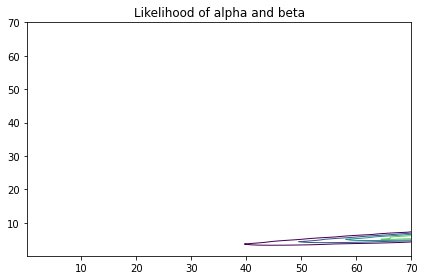

In [103]:
plot_contour(pd.DataFrame(like_hyper_all, 
                          index=alphas, 
                          columns=betas))
decorate(title="Likelihood of alpha and beta")

In [104]:
posterior_hyper_all = prior_hyper * like_hyper_all
posterior_hyper_all /= posterior_hyper_all.sum()

np.allclose(posterior_hyper_all, posterior_hyper)

True

True

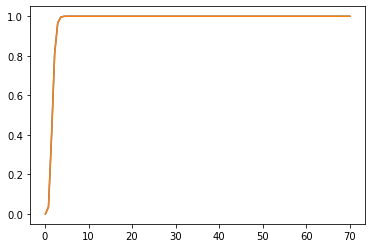

In [105]:
marginal_alpha2 = Pmf(posterior_hyper_all.sum(axis=1), prior_alpha.qs)
marginal_alpha2.make_cdf().plot()
marginal_alpha.make_cdf().plot()
np.allclose(marginal_alpha, marginal_alpha2)

True

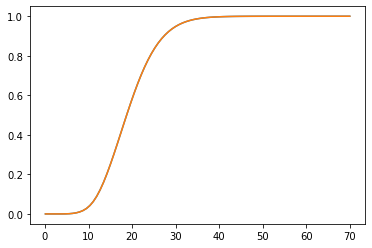

In [106]:
marginal_beta2 = Pmf(posterior_hyper_all.sum(axis=0), prior_beta.qs)
marginal_beta2.make_cdf().plot()
marginal_beta.make_cdf().plot()
np.allclose(marginal_beta, marginal_beta2)

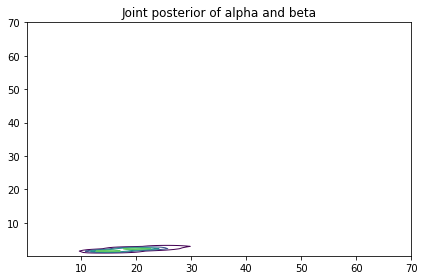

In [107]:
plot_contour(pd.DataFrame(posterior_hyper_all, 
                          index=alphas, 
                          columns=betas))
decorate(title="Joint posterior of alpha and beta")

In [108]:
i = 3
data = data_ns[i], data_ks[i]
data

(84, 7)

In [109]:
hyper_i = prior_hyper * like_hyper_all / likes_hyper[i]
hyper_i.sum()

5.2133580504524554e-20

In [110]:
prior_i = make_prior(hyper_i) 

In [111]:
posterior_i = update(prior_i, data)

<AxesSubplot:>

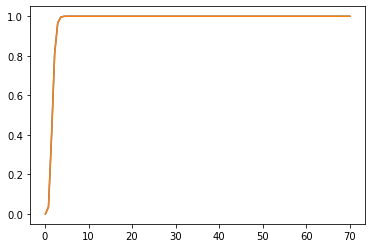

In [112]:
Pmf(marginal(posterior_i, 0), prior_alpha.qs).make_cdf().plot()
marginal_alpha.make_cdf().plot()

<AxesSubplot:>

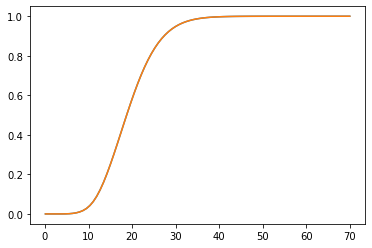

In [113]:
Pmf(marginal(posterior_i, 1), prior_beta.qs).make_cdf().plot()
marginal_beta.make_cdf().plot()

In [114]:
marginal_alpha = Pmf(marginal(posterior_i, 0), prior_alpha.qs)
marginal_beta = Pmf(marginal(posterior_i, 1), prior_beta.qs)
marginal_x = Pmf(marginal(posterior_i, 2), prior_x.qs)

2.074918525596109 2.1311780237162568


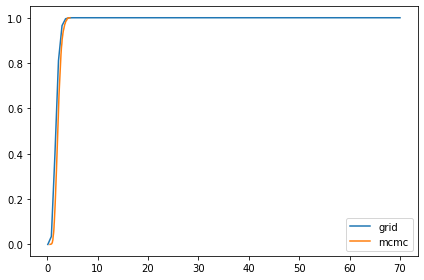

In [115]:
compare_cdf(marginal_alpha, trace['alpha'])

19.7389884492394 20.086811012780068


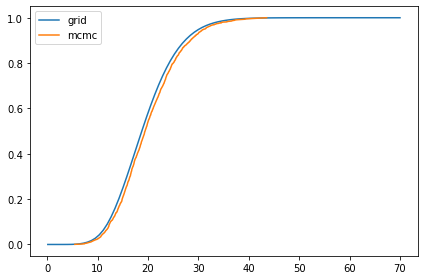

In [116]:
compare_cdf(marginal_beta, trace['beta'])

0.08579495500078008 0.08573227948087941


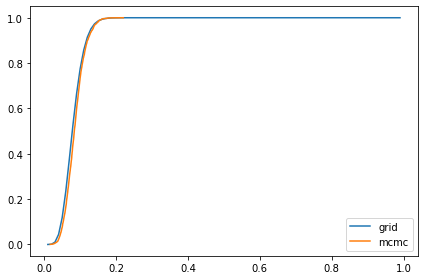

In [117]:
compare_cdf(marginal_x, trace_xs[i])